In [1]:
import pickle
import glob
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import pandas as pd

In [2]:
def load_data(dset, group=True):
    if dset == 'texas':
        path = "../../data/texas/texas_20m*"
    elif dset == 'purchase':
        path = "../../data/purchase/purchase_20m*"
    elif dset == 'cifar':
        path = "../../data/cifar/cifar_m*.p"
        
    
    idx_tups = []
    infos = []
    for file in glob.glob(path):
        f = pickle.load(open(file, 'rb'))
    
        if path == "../../data/cifar/cifar_m*.p":
            var = file.split("_")[-4:]
            if var[-4] == 'mb':
                var.insert(0,'dp')
            else:
                var.insert(0, 'is')
            var[-4] = 256
        else:
            var = file.split("_")[-5:]
            if var[-5] == '20mb' or var[-5] == 'mb':
                var[-5] = 'dp'
            else:
                var[-5] = 'is'
            var[-4] = int(var[-4])
        var[-1] = int(var[-1].split(".")[0])
        var[-3] = int(var[-3])
        var[-2] = float(var[-2]) if var[-2] != 'False' else False
    

        # IDX tups follow the format (epsilon, throw out threshold, batch size)
        for fd in f:
            idx_tups.append(var)
            infos.append(fd)
            
    inf_scalars = []
    for inf, idx in zip(infos, idx_tups):
        for i , (yt, yf, acc) in enumerate(zip(inf['yeom_tpr'], inf['yeom_fpr'], inf['acc'])):
            inf_scalars.append((i, acc, yt - yf, *idx))
    df = pd.DataFrame(inf_scalars)
    df.columns = ['epoch', 'acc', 'yeom', 'method', 'width', 'epsilon', 'throw out', 'batch_size']
    if group:
        grouped = df.groupby(['epoch', 'method', 'width', 'epsilon', 'throw out', 'batch_size']
              ).agg({'acc' : ['mean', 'std',], 'yeom': ['mean', 'std']}).reset_index()
        grouped.columns = ['epoch', 'method', 'width', 'epsilon', 'throw out', 'batch_size',
                   'acc','acc_std', 'yeom', 'yeom_std']
        return grouped
    else:
        return df

In [3]:
cifar = load_data('cifar')
texas = load_data('texas')
purchase = load_data('purchase')

In [4]:
cdp, cis = cifar[(cifar['method'] == 'dp')], cifar[(cifar['method'] == 'is')]
tdp, tis = texas[(texas['method'] == 'dp')], texas[(texas['method'] == 'is')]
pdp, pis = purchase[(purchase['method'] == 'dp')], purchase[(purchase['method'] == 'is')]

In [5]:
def is_pareto(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient
    
def plot_acc_yeom_pareto(ip, dp, axis, fill=False):
    dp = dp.sort_values('acc')
    ip = ip.sort_values('acc')
    
    dp_costs =  ((-1, 1, 1) * (dp[['acc', 'yeom', 'yeom_std']])).to_numpy()
    is_costs =  ((-1, 1, 1) * (ip[['acc', 'yeom', 'yeom_std']])).to_numpy()
    
    dp_mask = is_pareto(dp_costs[:, :2])
    is_mask = is_pareto(is_costs[:, :2])
    
    ip_idxes = ip.groupby(['method', 'width', 'epsilon', 'throw out', 'batch_size']).agg({'acc': 'idxmax'}).reset_index()['acc']
    dp_idxes = dp.groupby(['method', 'width', 'epsilon', 'throw out', 'batch_size']).agg({'acc': 'idxmax'}).reset_index()['acc']  
    
    axis.plot(0 - dp_costs[dp_mask, 0], dp_costs[dp_mask,1], '-x', c='C0', label='Gradient Clipping')
    axis.plot(0 - is_costs[is_mask, 0], is_costs[is_mask,1], '-x', c='C1', label='Immediate Sensitivity')
    #axis.errorbar(dp['acc'][dp_idxes], dp['yeom'][dp_idxes], fmt='o',c='C0',) # yerr=dp['yeom_std'][dp_idxes], xerr=dp['acc_std'][dp_idxes], )
    #axis.errorbar(ip['acc'][ip_idxes], ip['yeom'][ip_idxes], fmt='o',c='C1',)  #yerr=ip['yeom_std'][ip_idxes], xerr=ip['acc_std'][ip_idxes], )
    if fill:
        axis.fill_between(0 - dp_costs[dp_mask, 0],
                      dp_costs[dp_mask,1] + dp_costs[dp_mask,2],
                      dp_costs[dp_mask,1] - dp_costs[dp_mask,2],alpha=.3)
    
        axis.fill_between(0 - is_costs[is_mask, 0],
                      is_costs[is_mask,1] + is_costs[is_mask,2],
                      is_costs[is_mask,1] - is_costs[is_mask,2],alpha=.3)
    else:
        axis.scatter(dp['acc'], dp['yeom'], alpha=.1)
        axis.scatter(ip['acc'], ip['yeom'], alpha=.1)
    
    axis.set_xlabel('Accuracy')
    
    
    



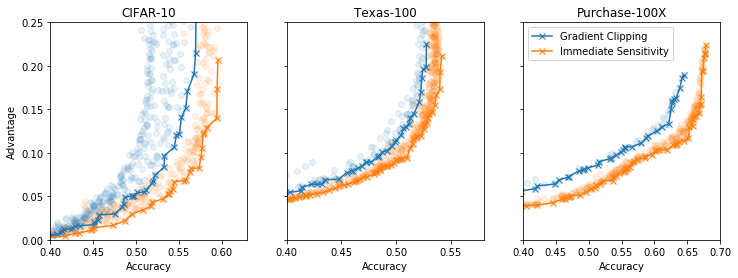

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 4)

ax1.set_xlabel('Advantage')

plot_acc_yeom_pareto(cis, cdp, ax1)
ax1.set_title('CIFAR-10')

plot_acc_yeom_pareto(tis, tdp, ax2)
ax2.set_title('Texas-100')


plot_acc_yeom_pareto(pis, pdp, ax3)
ax3.set_title('Purchase-100X')

ax1.set_ylim(0, .25)
ax2.set_ylim(0, .25)
ax3.set_ylim(0, .25)

ax1.set_xlim(.4, .63)
ax2.set_xlim(.4, .58)
ax3.set_xlim(.4, .7)
ax1.set_ylabel('Advantage')
ax3.legend()
plt.savefig('/home/ubuntu/6058f04dd79997b3e3ffcbad/figures/paretos.png', dpi=400)


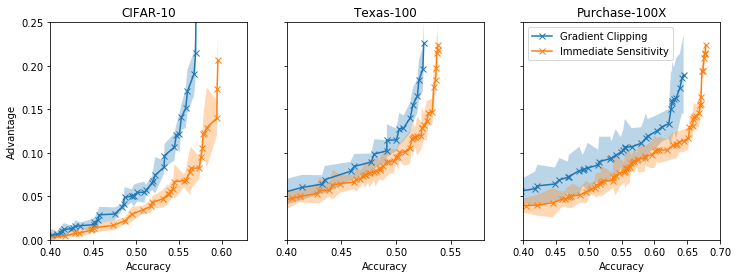

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 4)

ax1.set_xlabel('Advantage')

plot_acc_yeom_pareto(cis, cdp, ax1, fill=True)
ax1.set_title('CIFAR-10')

tex = tis[tis['width'] == 256]
ted = tdp[tdp['width'] == 256]

plot_acc_yeom_pareto(tex, ted, ax2,fill=True)
ax2.set_title('Texas-100')

plot_acc_yeom_pareto(pis, pdp, ax3, fill=True)
ax3.set_title('Purchase-100X')

ax1.set_ylim(0, .25)
ax2.set_ylim(0, .25)
ax3.set_ylim(0, .25)

ax1.set_xlim(.4, .63)
ax2.set_xlim(.4, .58)
ax3.set_xlim(.4, .7)

ax1.set_ylabel('Advantage')
ax3.legend()
plt.savefig('/home/ubuntu/6058f04dd79997b3e3ffcbad/figures/var_paretos.png', dpi=400)


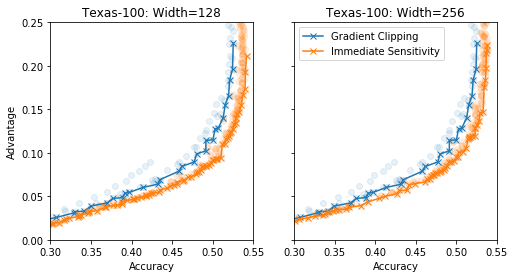

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(8, 4)
tex = tis[tis['width'] == 128]
ted = tdp[tdp['width'] == 256]

plot_acc_yeom_pareto(tex, ted, ax1,fill=False)
ax1.set_title('Texas-100: Width=128')

tex = tis[tis['width'] == 256]
ted = tdp[tdp['width'] == 256]

plot_acc_yeom_pareto(tex, ted, ax2,fill=False)
ax2.set_title('Texas-100: Width=256')


ax1.set_ylabel('Advantage')
ax2.legend()

ax1.set_xlim(.3, .55)
ax2.set_xlim(.3, .55)

ax1.set_ylim(0, .25)
ax2.set_ylim(0, .25)
plt.savefig('/home/ubuntu/6058f04dd79997b3e3ffcbad/figures/tex_paretos.png', dpi=400)

In [23]:
d = texas[texas['width'] == 256]

d[(d['yeom'] < .2) & (d['method'] == 'is')].sort_values('acc', ascending=False).head(1)

,epoch,method,width,epsilon,throw out,batch_size,acc,acc_std,yeom,yeom_std
804,13,is,256,50000,0.0,64,0.536639,0.007997,0.197068,0.018988


In [17]:
.48, .52, .53
.51, .53, .54

.48, .51, .53

.50, .53, .54

(0.51, 0.53, 0.54)